In [30]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Flatten, Input
from tensorflow.keras.models import Model
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from tabnet_keras import TabNetRegressor, TabNetClassifier





In [ ]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../../../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from config.config import *
# from libs.common import *

c:\Users\Admin\Data\ads_fraud_detection


In [32]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print('Using GPU:', gpus[0])  # In ra tên của GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
else:
    print('No GPU found. Using CPU.')

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [33]:
save_dir=f"{exps_dir}/exp4/exp_base"
if os.path.exists(save_dir) == False: 
  os.makedirs(save_dir, exist_ok=True)



test_size=0.33
seed=42

In [34]:
# feature_selection=dict(np.load(f'{save_dir}/feature_model_selection.npz',allow_pickle=True))['feature_model_selection']
# feature_selection = {key: value for key, value in feature_selection.item().items()}
# feature_selection

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [35]:
# bg_model=joblib.load(f'{save_dir}/bg_model.joblib')
# rf_model=joblib.load(f'{save_dir}/rf_model.joblib')
# svm_model=joblib.load(f'{save_dir}/svm_model.joblib')

In [ ]:
x_train=pd.read_csv(f'{save_dir}/x_train.csv')
y_train=pd.read_csv(f'{save_dir}/y_train.csv')
x_test=pd.read_csv(f'{save_dir}/x_test.csv')
y_test=pd.read_csv(f'{save_dir}/y_test.csv')
class_weights_dict=dict(np.load(f'{save_dir}/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 0.5317035512094699, 1: 8.385551948051948}

In [37]:


# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    encoder = OneHotEncoder(sparse_output=False)
    
    labels_reshaped = labels.reshape(-1, 1)
    
    encoder.fit(labels_reshaped)
    
    onehot_labels = encoder.transform(labels_reshaped)
    # onehot_labels=pd.DataFrame(onehot_labels)
    return onehot_labels

y_train_onehot=oneHot(y_train)
y_test_onehot=oneHot(y_test)
print(y_test_onehot.shape,y_train_onehot.shape)


(5089, 2) (10331, 2)


In [38]:
y_test_onehot.reshape(-1, 1)
print(y_test_onehot.shape)

(5089, 2)


In [39]:
x_test.shape

(5089, 33)

In [40]:
x_train.shape

(10331, 33)

In [41]:
def f1_score(y_true, y_pred):
    """
    Macro F1 score metric.
    """
    y_pred = K.round(y_pred)    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)    
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())    
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())    
    macro_f1_score = K.mean(f1_scores)
    
    return macro_f1_score

In [42]:
print(x_train.shape[1])

33


#### * Xây dựng model:

#### * Xây dựng Stacked_model:

In [43]:
def f1_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Calculate true positives, predicted positives, and possible positives for each class
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    predicted_positives = tf.reduce_sum(y_pred, axis=0)
    possible_positives = tf.reduce_sum(y_true, axis=0)
    
    # Calculate precision and recall for each class
    precision = tp / (predicted_positives + tf.keras.backend.epsilon())
    recall = tp / (possible_positives + tf.keras.backend.epsilon())
    
    # Calculate F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    # Calculate the macro F1 score
    f1_macro = tf.reduce_mean(f1)
    
    # Return the F1 loss
    return 1 - f1_macro

In [44]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred, smooth=0.0001):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [45]:
# -*- coding: utf-8 -*-
"""Inception-ResNet V2 model for Keras.

Model naming and structure follows TF-slim implementation (which has some additional
layers and different number of filters from the original arXiv paper):
https://github.com/tensorflow/models/blob/master/slim/nets/inception_resnet_v2.py

Pre-trained ImageNet weights are also converted from TF-slim, which can be found in:
https://github.com/tensorflow/models/tree/master/slim#pre-trained-models

# Reference
- [Inception-v4, Inception-ResNet and the Impact of
   Residual Connections on Learning](https://arxiv.org/abs/1602.07261)

"""
from __future__ import print_function
from __future__ import absolute_import

import warnings
import numpy as np
from keras.layers import Input, Conv1D, BatchNormalization, Activation, add, MaxPooling1D, GlobalAveragePooling1D,AveragePooling1D,Concatenate, Dense
from keras.models import Model
import keras.backend as K




def preprocess_input(x):
    """Preprocesses a numpy array encoding a batch of images.

    This function applies the "Inception" preprocessing which converts
    the RGB values from [0, 255] to [-1, 1]. Note that this preprocessing
    function is different from `imagenet_utils.preprocess_input()`.

    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].

    # Returns
        Preprocessed array.
    """
    x /= 255.
    x -= 0.5
    x *= 2.
    return x


def conv1d_bn(x,
              filters,
              kernel_size,
              strides=1,
              padding='same',
              activation='relu',
              name=None):
    bn_axis=1
    x = Conv1D(filters,
               kernel_size,
               strides=strides,
               padding=padding,
               name=name)(x)
    bn_name = None if name is None else name + '_bn'
    x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    if activation is not None:
        ac_name = None if name is None else name + '_ac'
        x = Activation(activation, name=ac_name)(x)
    return x

from keras.layers import Lambda, ZeroPadding1D

def adjust_padding(branches):
    max_length = max(K.int_shape(branch)[1] for branch in branches)
    adjusted_branches = []
    for branch in branches:
        branch_length = K.int_shape(branch)[1]
        if branch_length < max_length:
            padding = max_length - branch_length
            branch = ZeroPadding1D(padding=(0, padding))(branch)
        adjusted_branches.append(branch)
    return adjusted_branches

def check_and_adjust_branches(branches, channel_axis):
    max_length = max([K.int_shape(branch)[channel_axis] for branch in branches])
    adjusted_branches = []
    for branch in branches:
        branch_length = K.int_shape(branch)[channel_axis]
        if branch_length != max_length:
            # Adjust the size of the branch
            # This can be done using ZeroPadding1D, Cropping1D, or other methods
            # For example, using ZeroPadding1D:
            padding_size = (max_length - branch_length)
            padding = (padding_size // 2, padding_size - padding_size // 2)
            branch = ZeroPadding1D(padding=padding)(branch)
        adjusted_branches.append(branch)
    return adjusted_branches

def adjust_branches_for_concat(branches):
    adjusted_branches = []
    for branch in branches:
        if K.int_shape(branch)[2] != 96:
            # Thêm đệm để kích thước chiều kênh tăng lên 96
            padding_size = 96 - K.int_shape(branch)[2]
            left_pad = padding_size // 2
            right_pad = padding_size - left_pad
            branch = ZeroPadding1D(padding=(left_pad, right_pad))(branch)
        adjusted_branches.append(branch)
    return adjusted_branches


def inception_resnet_block(x, scale, block_type, block_idx, activation='relu'):
 
    if block_type == 'block35':
        target_length = K.int_shape(x)[1]
        branch_0 = conv1d_bn(x, 32, 1)
        branch_1 = conv1d_bn(x, 32, 1)
        branch_1 = conv1d_bn(branch_1, 32, 3)
        branch_2 = conv1d_bn(x, 32, 1)
        branch_2 = conv1d_bn(branch_2, 48, 3)
        branch_2 = conv1d_bn(branch_2, 64, 3)
        branches = [branch_0, branch_1, branch_2]
    elif block_type == 'block17':
        target_length = K.int_shape(x)[1]
        branch_0 = conv1d_bn(x, 192, 1)
        branch_1 = conv1d_bn(x, 128, 1)
        branch_1 = conv1d_bn(branch_1, 160, 1)
        branch_1 = conv1d_bn(branch_1, 192, 7)
        branches = [branch_0, branch_1]
    elif block_type == 'block8':
        target_length = K.int_shape(x)[1]
        branch_0 = conv1d_bn(x, 192, 1)
        branch_1 = conv1d_bn(x, 192, 1)
        branch_1 = conv1d_bn(branch_1, 224, 1)
        branch_1 = conv1d_bn(branch_1, 256, 3)
        branches = [branch_0, branch_1]
    else:
        raise ValueError('Unknown Inception-ResNet block type. '
                         'Expects "block35", "block17" or "block8", '
                         'but got: ' + str(block_type))

    block_name = block_type + '_' + str(block_idx)
    channel_axis = -1
    branches = check_and_adjust_branches(branches, channel_axis=1)
    mixed = Concatenate(axis=channel_axis, name=block_name + '_mixed')(branches)
    up = conv1d_bn(mixed,
                   K.int_shape(x)[channel_axis],
                   1,
                   activation=None,
                   name=block_name + '_conv')

    x = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
               output_shape=K.int_shape(x)[1:],
               arguments={'scale': scale},
               name=block_name)([x, up])
    if activation is not None:
        x = Activation(activation, name=block_name + '_ac')(x)
    return x





In [ ]:
def InceptionResNetV2():

    # Determine proper input shape
    input_shape =(56,1)
    x_input = Input(shape=input_shape)

    # Stem block: 35 x 35 x 192
    x = conv1d_bn(x_input, 16, 3, strides=2, padding='valid')
    x = conv1d_bn(x, 16, 3, padding='valid')
    x = conv1d_bn(x, 32, 3)
    x = MaxPooling1D(3, strides=2)(x)
    x = conv1d_bn(x, 80, 1, padding='valid')
    x = conv1d_bn(x, 192, 3, padding='valid')
    x = MaxPooling1D(3, strides=2)(x)

    # Mixed 5b (Inception-A block): 35 x 35 x 160
    branch_0 = conv1d_bn(x, 64, 1)
    branch_1 = conv1d_bn(x, 48, 1)
    branch_1 = conv1d_bn(branch_1, 32, 5)
    branch_2 = conv1d_bn(x, 32, 1)
    branch_2 = conv1d_bn(branch_2, 64, 3)
    branch_2 = conv1d_bn(branch_2, 64, 3)
    branch_pool = AveragePooling1D(3, strides=1, padding='same')(x)
    branch_pool = conv1d_bn(branch_pool, 32, 1)
    target_shape = (None, 2, 64)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    channel_axis = -1
    #branches = adjust_branches_for_concat(branches)
    x = Concatenate(axis=-1, name='mixed_5b')(branches)

    # 10x block35 (Inception-ResNet-A block): 35 x 35 x 160
    for block_idx in range(1, 11):
        x = inception_resnet_block(x,
                                   scale=0.17,
                                   block_type='block35',
                                   block_idx=block_idx)

    # Mixed 6a (Reduction-A block): 17 x 17 x 1088
    branch_0 = conv1d_bn(x, 128, 3, strides=2, padding='same')
    branch_1 = conv1d_bn(x, 96, 1)
    branch_1 = conv1d_bn(branch_1, 96, 3)
    branch_1 = conv1d_bn(branch_1, 128, 3, strides=2, padding='same')
    branch_pool = MaxPooling1D(3, strides=2, padding='same')(x)
    branches = [branch_0, branch_1, branch_pool]
    x = Concatenate(axis=channel_axis, name='mixed_6a')(branches)

    # 20x block17 (Inception-ResNet-B block): 17 x 17 x 1088
    for block_idx in range(1, 21):
        x = inception_resnet_block(x,
                                   scale=0.1,
                                   block_type='block17',
                                   block_idx=block_idx)

    # Mixed 7a (Reduction-B block): 8 x 8 x 2080
    branch_0 = conv1d_bn(x, 96, 1)
    branch_0 = conv1d_bn(branch_0, 128, 3, strides=2, padding='same')
    branch_1 = conv1d_bn(x, 96, 1)
    branch_1 = conv1d_bn(branch_1, 288, 3, strides=2, padding='same')
    branch_2 = conv1d_bn(x, 96, 1)
    branch_2 = conv1d_bn(branch_2, 288, 3)
    branch_2 = conv1d_bn(branch_2, 128, 3, strides=2, padding='same')
    branch_pool = MaxPooling1D(3, strides=2, padding='same')(x)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    x = Concatenate(axis=channel_axis, name='mixed_7a')(branches)

    # 10x block8 (Inception-ResNet-C block): 8 x 8 x 2080
    for block_idx in range(1, 10):
        x = inception_resnet_block(x,
                                   scale=0.2,
                                   block_type='block8',
                                   block_idx=block_idx)
    x = inception_resnet_block(x,
                               scale=1.,
                               activation=None,
                               block_type='block8',
                               block_idx=10)

    # Final convolution block: 8 x 8 x 1536
    x = conv1d_bn(x, 1536, 1, name='conv_7b')
    x = GlobalAveragePooling1D(name='avg_pool')(x)
    x = Dense(2, activation='softmax', name='predictions')(x)

 

    # Create model
    model = Model(x_input, x, name='inception_resnet_v2')

    

    return model


model = InceptionResNetV2()
lr=0.0001
# model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=lr), loss=dice_coef_loss, metrics=['accuracy',f1_score])
early_stopping = EarlyStopping(monitor='val_loss',
                                mode='min',
    min_delta=0.00005,
    patience=100,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=20,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',  # Đường dẫn để lưu model
    monitor='val_loss',  # Theo dõi val_loss
    mode='min',
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1  # Hiển thị thông báo khi lưu model
)


model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 33, 1)]      0           []                               
                                                                                                  
 conv1d_203 (Conv1D)            (None, 16, 16)       64          ['input_2[0][0]']                
                                                                                                  
 batch_normalization_203 (Batch  (None, 16, 16)      48          ['conv1d_203[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_203 (Activation)    (None, 16, 16)       0           ['batch_normali

c:\ProgramData\miniconda3\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 Normalization)                                                                                   
                                                                                                  
 batch_normalization_255 (Batch  (None, 1, 48)       3           ['conv1d_255[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_252 (Activation)    (None, 1, 32)        0           ['batch_normalization_252[0][0]']
                                                                                                  
 activation_255 (Activation)    (None, 1, 48)        0           ['batch_normalization_255[0][0]']
                                                                                                  
 conv1d_251 (Conv1D)            (None, 1, 32)        6176        ['block35_6_ac[0][0]']           
          

In [47]:
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 33, 1)]      0           []                               
                                                                                                  
 conv1d_203 (Conv1D)            (None, 16, 16)       64          ['input_2[0][0]']                
                                                                                                  
 batch_normalization_203 (Batch  (None, 16, 16)      48          ['conv1d_203[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_203 (Activation)    (None, 16, 16)       0           ['batch_normali

In [ ]:
x_train = x_train.astype(np.int32)  
x_train = tf.convert_to_tensor(x_train, dtype=tf.int32)
y_train_onehot = y_train_onehot.astype(np.int32)  
y_train_onehot = tf.convert_to_tensor(y_train_onehot, dtype=tf.int32)

In [ ]:
x_test = x_test.astype(np.int32)  
x_test = tf.convert_to_tensor(x_test, dtype=tf.int32)
y_test_onehot = y_test_onehot.astype(np.int32)  
y_test_onehot = tf.convert_to_tensor(y_test_onehot, dtype=tf.int32)

In [49]:
model.fit(x=x_train, y=y_train_onehot,
          validation_data=(x_test, y_test_onehot),
          batch_size=256,
          epochs=1200,
          callbacks=[early_stopping, lr_scheduler])

Epoch 1/1200
323/323 [==============================] - 137s 315ms/step - loss: 0.2386 - accuracy: 0.9404 - f1_score: 0.4844 - val_loss: 0.2147 - val_accuracy: 0.9397 - val_f1_score: 0.4843 - lr: 1.0000e-04
Epoch 2/1200
323/323 [==============================] - 95s 293ms/step - loss: 0.2059 - accuracy: 0.9404 - f1_score: 0.4844 - val_loss: 0.2048 - val_accuracy: 0.9397 - val_f1_score: 0.4843 - lr: 1.0000e-04
Epoch 3/1200
323/323 [==============================] - 94s 290ms/step - loss: 0.1994 - accuracy: 0.9404 - f1_score: 0.4844 - val_loss: 0.1998 - val_accuracy: 0.9397 - val_f1_score: 0.4843 - lr: 1.0000e-04
Epoch 4/1200
323/323 [==============================] - 94s 292ms/step - loss: 0.1953 - accuracy: 0.9404 - f1_score: 0.4844 - val_loss: 0.1990 - val_accuracy: 0.9397 - val_f1_score: 0.4843 - lr: 1.0000e-04
Epoch 5/1200
323/323 [==============================] - 69s 214ms/step - loss: 0.1914 - accuracy: 0.9404 - f1_score: 0.4844 - val_loss: 0.1970 - val_accuracy: 0.9397 - val_f1_

In [ ]:
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 33, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 16, 16)       64          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16)      48          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 16)       0           ['batch_normali

#### * Kết quả đánh giá mô hình:

In [ ]:
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 33, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 16, 16)       64          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16)      48          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 16)       0           ['batch_normali

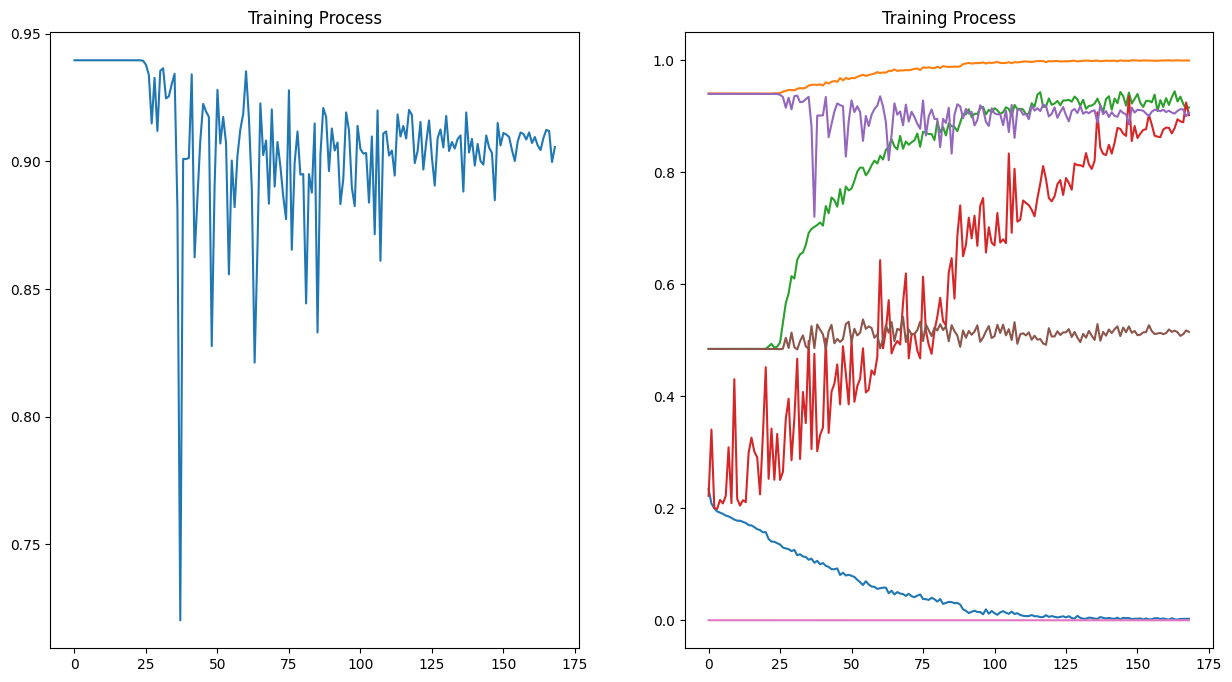

<Figure size 640x480 with 0 Axes>

In [ ]:
history=model.history.history
fig,axes=plt.subplots(1,2, figsize=(15,8))
axes[0].plot(pd.DataFrame(history['val_accuracy']))
axes[0].set_title('Training Process')
axes[1].plot(pd.DataFrame(history))
axes[1].set_title('Training Process')
plt.show()
plt.savefig('train.png')

In [ ]:
y_test_labels = np.argmax(y_test_onehot, axis=1)
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_test_labels, predictions)
accuracy


160/160 [==============================] - 7s 22ms/step


0.8834741599528395

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

y_test_labels = np.argmax(y_test_onehot, axis=1)

accuracy = accuracy_score(y_test_labels, predictions)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test_labels, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, predictions))


Accuracy: 0.8834741599528395
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      4782
           1       0.15      0.21      0.18       307

    accuracy                           0.88      5089
   macro avg       0.55      0.57      0.56      5089
weighted avg       0.90      0.88      0.89      5089

Confusion Matrix:
[[4433  349]
 [ 244   63]]


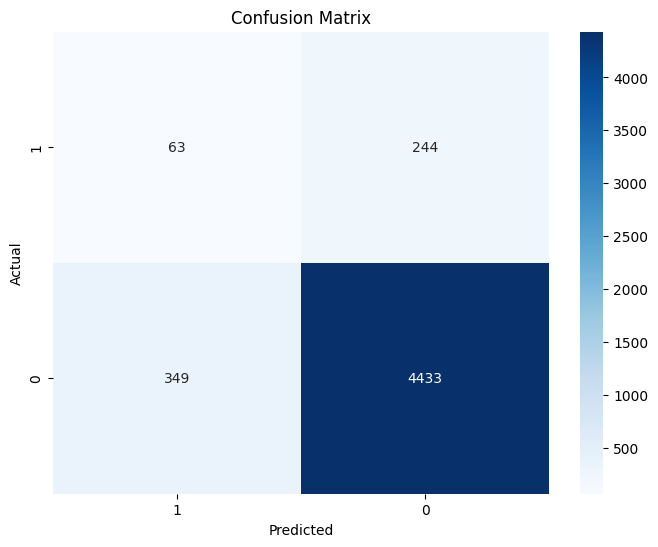

In [ ]:
# Dự đoán


# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

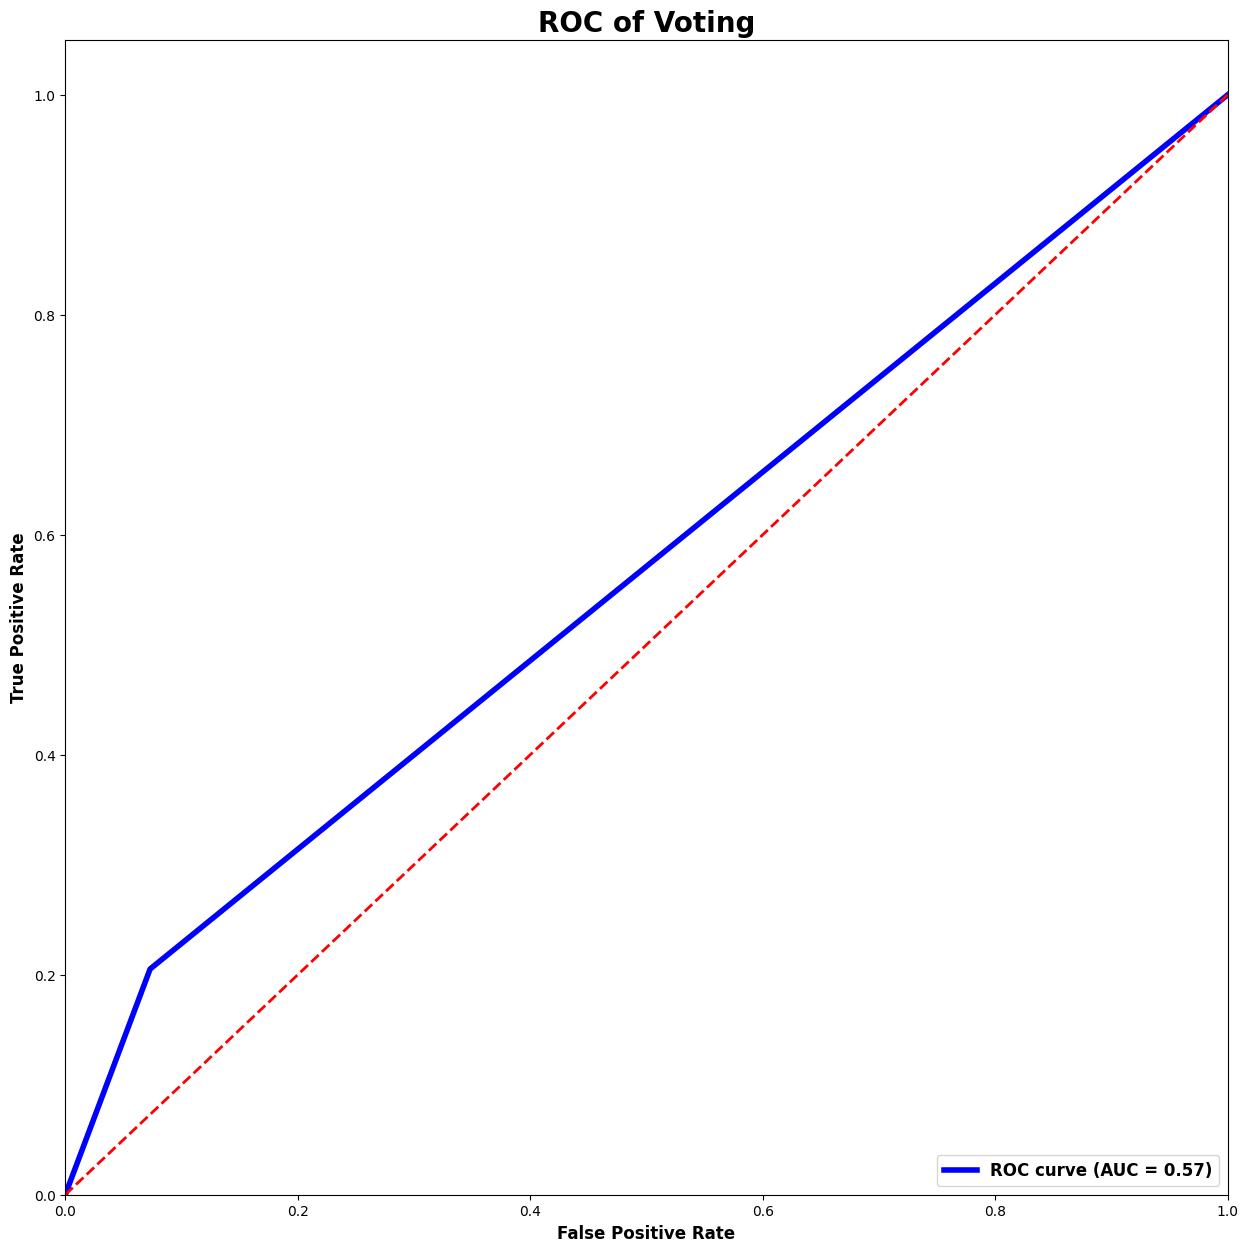

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

fpr, tpr, _ = roc_curve(y_test, predictions)
    
roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, lw=4, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  
ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   
ax.set_title(f'ROC of Voting',fontsize=20, weight='bold')  
ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'}) 
plt.show()

In [ ]:
def check_result(prediction):
    prediction = (prediction > 0.2).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [ ]:
# solandung=0
# hopdonggianlan=0
# for indx in range(len(x_test)):
#     y_predict = stacked_model.predict(stacked_input)
#     stacked_pred_labels = y_predict.argmax(axis=1)

#     #print(y_predict[0][0])
#     Y_check = check_result(y_test.iloc[indx])
#     print('True:', Y_check)
#     print('Predicted:', check_result(stacked_pred_labels[indx]))
#     print("----------------------------")
#     if Y_check==check_result(stacked_pred_labels[indx]):
#         solandung+=1
#         if Y_check=='Y':
#             hopdonggianlan+=1
    